In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory
from pprint import pprint
import spacy
import numpy as np

In [2]:
class Config:
    SEED: int = 42
    SAMPLE: int = 10000
    BASE_DATA_PATH: str = '../data/'

In [3]:
file_path = f'{Config.BASE_DATA_PATH}/arXiv_scientific dataset.csv'

raw_df = pd.read_csv(file_path)

In [4]:
raw_df.describe()

,summary_word_count
count,136238.000000
mean,162.386830
std,49.374474
min,1.000000
25%,128.000000
50%,160.000000
75%,195.000000
max,552.000000


In [5]:
raw_df.head()

,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count
0,cs-9308101v1,Dynamic Backtracking,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. L. Ginsberg'],'M. L. Ginsberg',Because of their occasional need to return to ...,79
1,cs-9308102v1,A Market-Oriented Programming Environment and ...,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. P. Wellman'],'M. P. Wellman',Market price systems constitute a well-underst...,119
2,cs-9309101v1,An Empirical Analysis of Search in GSAT,Artificial Intelligence,cs.AI,9/1/93,9/1/93,"['I. P. Gent', 'T. Walsh']",'I. P. Gent',We describe an extensive study of search in GS...,167
3,cs-9311101v1,The Difficulties of Learning Logic Programs wi...,Artificial Intelligence,cs.AI,11/1/93,11/1/93,"['F. Bergadano', 'D. Gunetti', 'U. Trinchero']",'F. Bergadano',As real logic programmers normally use cut (!)...,174
4,cs-9311102v1,Software Agents: Completing Patterns and Const...,Artificial Intelligence,cs.AI,11/1/93,11/1/93,"['J. C. Schlimmer', 'L. A. Hermens']",'J. C. Schlimmer',To support the goal of allowing users to recor...,187


In [6]:
raw_df['category'].value_counts()

category
Machine Learning                                          39986
Computer Vision and Pattern Recognition                   29057
Computation and Language (Natural Language Processing)    25202
Artificial Intelligence                                   12969
Machine Learning (Statistics)                             10447
                                                          ...  
Nuclear Experiment                                            1
Superconductivity                                             1
Pattern Formation and Solitons                                1
General Mathematics                                           1
History and Philosophy of Physics                             1
Name: count, Length: 138, dtype: int64

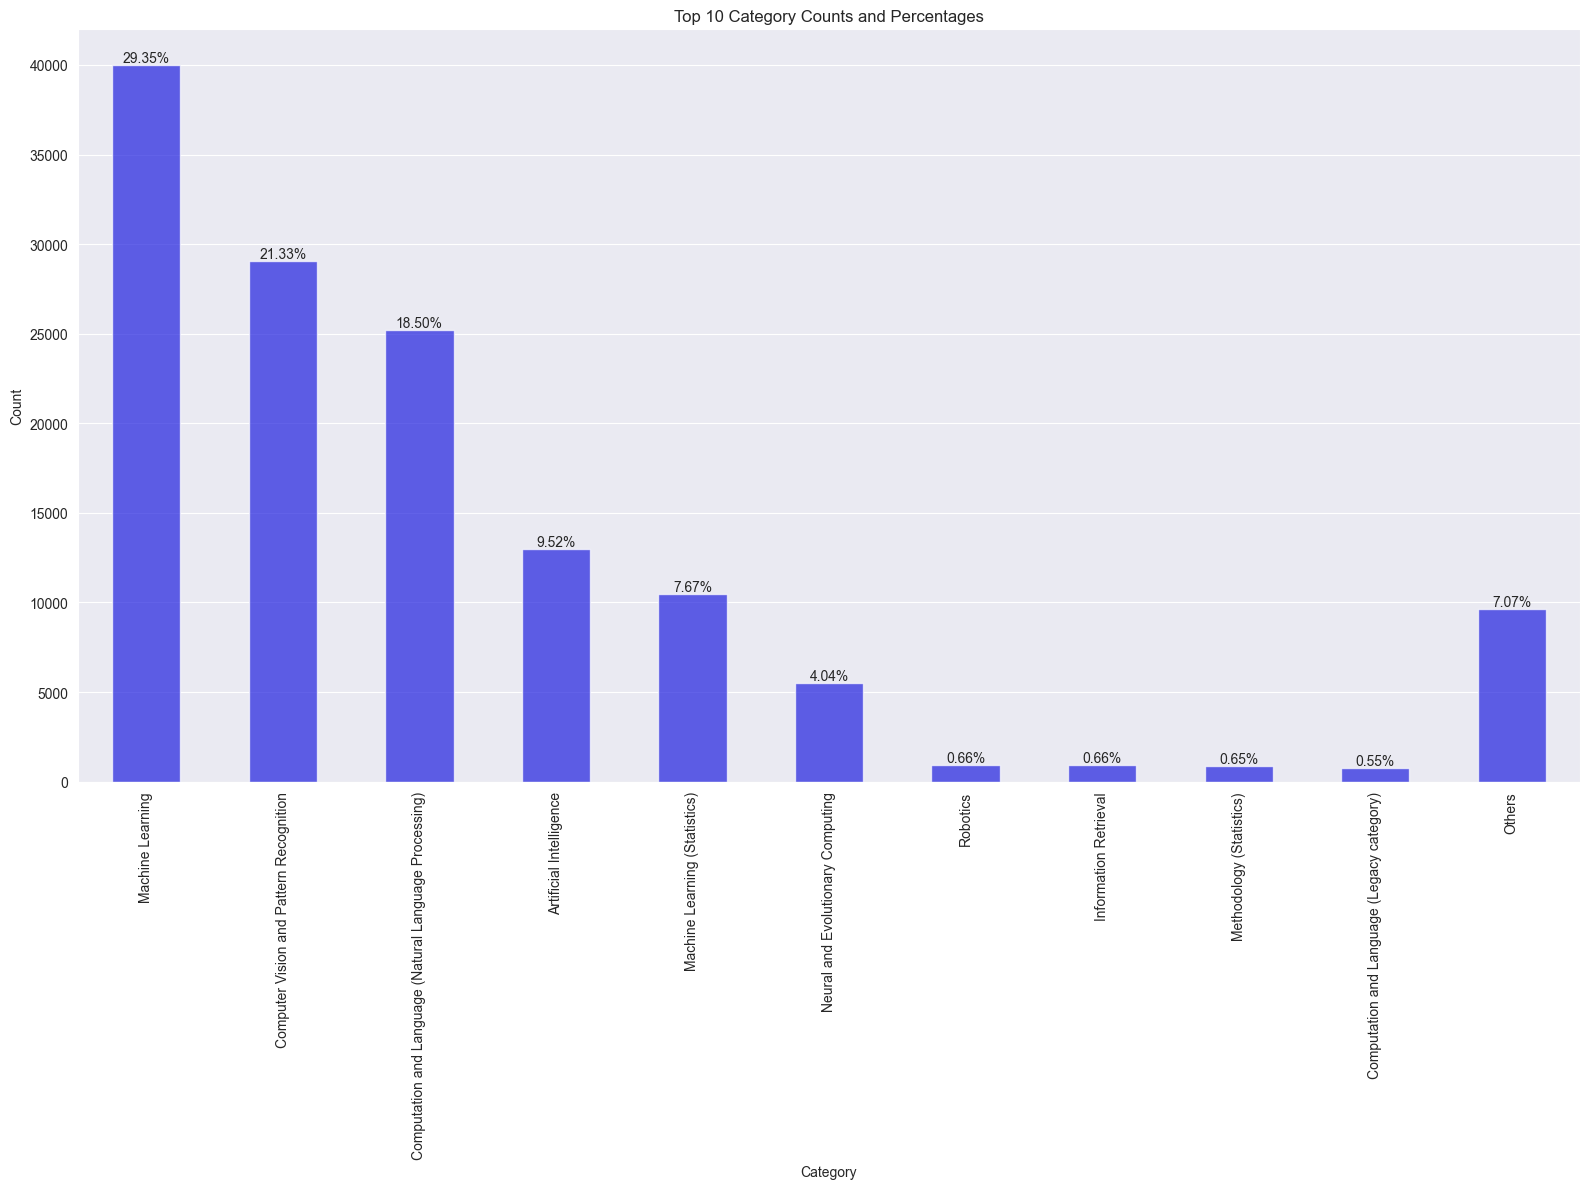

In [8]:
# Calculate the counts of the categories
category_counts = raw_df['category'].value_counts()

# Select the top 10 categories and group the rest into 'Others'
top_categories = category_counts.head(10)
other_categories = category_counts.iloc[10:].sum()


# Create a new category that includes 'Others'
category_counts_modified = pd.concat([top_categories, pd.Series({'Others': other_categories})])
# Calculate the percentages
category_percentages = category_counts_modified / category_counts_modified.sum() * 100

# Combine counts and percentages into a DataFrame
category_df = pd.DataFrame({
    'count': category_counts_modified,
    'percentage': category_percentages
}).reset_index()
category_df.columns = ['category', 'count', 'percentage']

# Create a Seaborn bar plot
plt.figure(figsize=(16, 12))
sns.barplot(x='category', y='count', data=category_df, color='blue', alpha=0.7, width=0.5)

# Annotate percentages on top of bars
for i in range(len(category_df)):
    plt.text(i, category_df['count'].iloc[i] + 0.5, f'{category_df["percentage"].iloc[i]:.2f}%', 
             ha='center', va='bottom', fontsize=10)

plt.title('Top 10 Category Counts and Percentages')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [9]:
df = raw_df.sample(Config.SAMPLE, random_state=Config.SEED)
del raw_df

In [10]:
df.isnull().values.any()

np.False_

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 78358 to 58556
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  10000 non-null  object
 1   title               10000 non-null  object
 2   category            10000 non-null  object
 3   category_code       10000 non-null  object
 4   published_date      10000 non-null  object
 5   updated_date        10000 non-null  object
 6   authors             10000 non-null  object
 7   first_author        10000 non-null  object
 8   summary             10000 non-null  object
 9   summary_word_count  10000 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 859.4+ KB


In [12]:
DetectorFactory.seed = Config.SEED

languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['summary'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 10000/10000 [00:16<00:00, 621.01it/s]


In [13]:
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 10000

{'en': 10000}


In [14]:
print(f'In summary, there are {languages_dict}')

In summary, there are {'en': 10000}


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 78358 to 58556
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  10000 non-null  object
 1   title               10000 non-null  object
 2   category            10000 non-null  object
 3   category_code       10000 non-null  object
 4   published_date      10000 non-null  object
 5   updated_date        10000 non-null  object
 6   authors             10000 non-null  object
 7   first_author        10000 non-null  object
 8   summary             10000 non-null  object
 9   summary_word_count  10000 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 859.4+ KB


/var/folders/m_/m2qplsqx2p760zbv9t6sqyj40000gn/T/ipykernel_14234/1152327472.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  published_date = pd.to_datetime(df['published_date'])


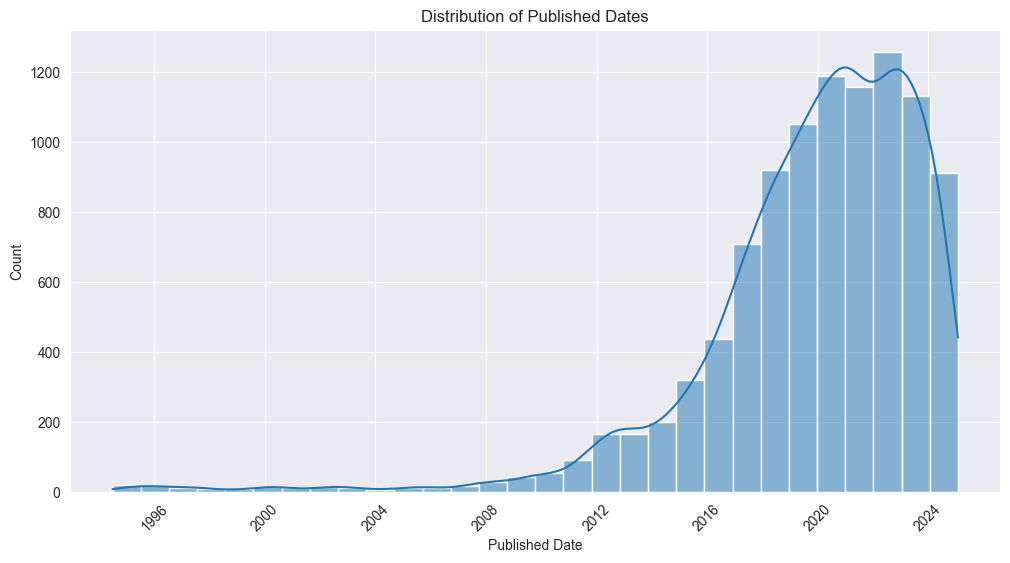

In [16]:
published_date = pd.to_datetime(df['published_date'])

plt.figure(figsize=(12, 6))
sns.histplot(published_date, bins=30, kde=True)  # Adjust bins as needed
plt.xticks(rotation=45)
plt.xlabel("Published Date")
plt.ylabel("Count")
plt.title("Distribution of Published Dates")
plt.show()

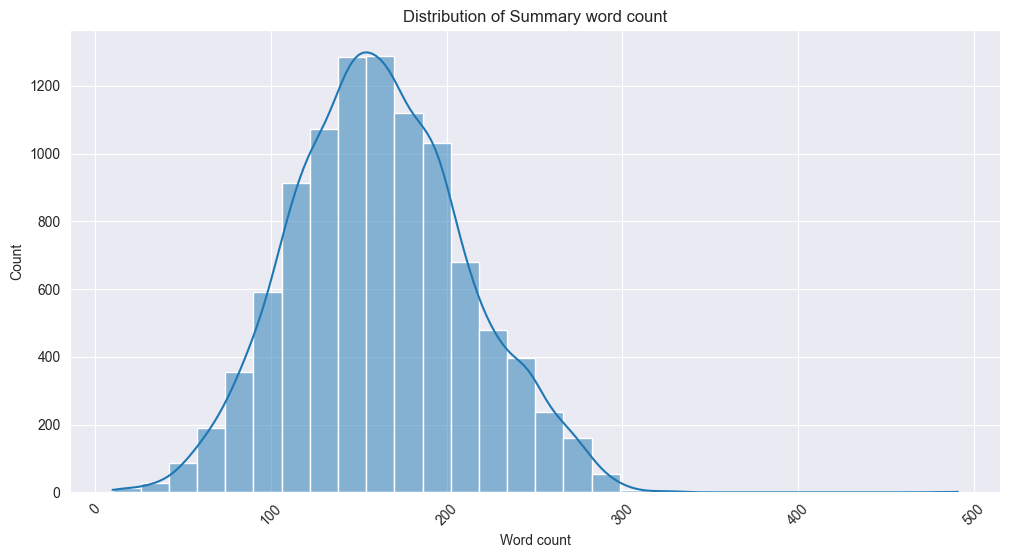

In [17]:
plt.figure(figsize=(12, 6))
sns.histplot(df['summary_word_count'], bins=30, kde=True)  # Adjust bins as needed
plt.xticks(rotation=45)
plt.xlabel("Word count")
plt.ylabel("Count")
plt.title("Distribution of Summary word count")
plt.show()

In [18]:
from spacy.lang.en.stop_words import STOP_WORDS

stopwords = list(STOP_WORDS)
print(f'{len(stopwords)=}')
print(f'{stopwords[:10]=}')

len(stopwords)=326
stopwords[:10]=['but', 'his', 'because', 'could', 'fifteen', 'for', 'quite', 'almost', 'our', 'being']


In [19]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]

In [22]:
# python -m spacy download en_core_web_sm
# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

for w in custom_stop_words:
    nlp.vocab[w].is_stop = True  # Proper way to add stop words in spaCy


In [23]:
def text_tokenizer(text: str) -> spacy.__doc__ :
    doc = nlp(text)

    # Analyze syntax
    print(f'Original text:\n{text}')
    print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
    print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

    # Find named entities, phrases and concepts
    for entity in doc.ents:
        print(entity.text, entity.label_)


text_tokenizer(df['summary'].iloc[0])

Original text:
The preceding three decades have seen the emergence, rise, and proliferation
of machine learning (ML). From half-recognised beginnings in perceptrons,
neural nets, and decision trees, algorithms that extract correlations (that is,
patterns) from a set of data points have broken free from their origin in
computational cognition to embrace all forms of problem solving, from voice
recognition to medical diagnosis to automated scientific research and
driverless cars, and it is now widely opined that the real industrial
revolution lies less in mobile phone and similar than in the maturation and
universal application of ML. Among the consequences just might be the triumph
of anti-realism over realism.
Noun phrases: ['The preceding three decades', 'the emergence', 'rise', 'proliferation', 'machine learning', 'ML', 'half-recognised beginnings', 'perceptrons', 'neural nets', 'decision trees', 'that', 'correlations', 'that', ',\npatterns', 'a set', 'data points', 'their origin', '

In [24]:
doc = nlp(df['summary'].iloc[0])

In [25]:
tqdm.pandas()
X = df['summary'].swifter.apply(nlp)

Pandas Apply:   0%|          | 0/10000 [00:00<?, ?it/s]

In [26]:
X.apply(lambda e: e.vector)

78358     [0.08470676, -0.14392062, -0.005347162, -0.124...
37291     [-0.13507216, -0.18408585, -0.083812654, -0.04...
132977    [0.081840456, -0.22340725, -0.070830576, -0.00...
69011     [-0.039916355, -0.18810062, -0.06540312, 0.005...
57403     [0.008648996, -0.17962249, -0.11650918, 0.0431...
                                ...                        
92547     [-0.053615812, -0.14528427, 0.015384023, 0.134...
82108     [0.09157365, -0.16143999, 0.043259654, -0.0050...
87723     [0.03478363, -0.24211355, 0.013000924, 0.09063...
56538     [0.1668089, -0.076187305, -0.028154973, 0.0690...
58556     [0.06214854, -0.13858558, -0.06528212, 0.00534...
Name: summary, Length: 10000, dtype: object

In [27]:
from sklearn.decomposition import PCA

X_array = np.vstack(X.apply(lambda e: e.vector).values)

pca = PCA(n_components=0.95, random_state=Config.SEED)
X_reduced = pca.fit_transform(X_array)

print(f'Original dimension {X_array.shape}')
print(f'Reduced dimension {X_reduced.shape}')

Original dimension (10000, 96)
Reduced dimension (10000, 62)


In [28]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

In [29]:
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 30)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

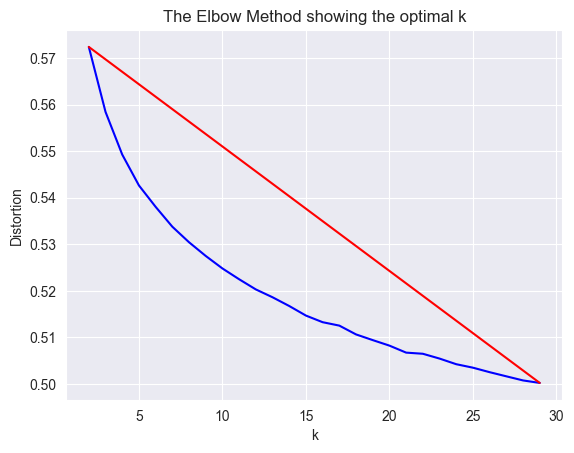

In [30]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [31]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)

In [32]:
X_reduced

array([[ 4.5601249e-02, -2.5341007e-01, -2.8517115e-01, ...,
         4.0185302e-03, -1.6864620e-02,  2.3600414e-02],
       [ 4.6037841e-01, -3.0154073e-01, -3.9423317e-02, ...,
         2.1576773e-02, -1.3346083e-02,  1.3926759e-02],
       [-1.5002844e-01,  2.4258375e-02,  4.6109155e-02, ...,
        -4.8103675e-02, -1.3583280e-02, -2.6464723e-02],
       ...,
       [-1.6864124e-01,  1.8785608e-01,  3.9097786e-02, ...,
        -1.5514124e-02,  2.8600886e-02,  1.7335191e-02],
       [-1.4951196e-01,  7.7057660e-02, -1.3113639e-01, ...,
         4.9731333e-02,  6.3238174e-02,  4.0260777e-02],
       [ 9.3732029e-02,  2.4296480e-01,  3.1795621e-02, ...,
         1.1873245e-04, -5.5931456e-02, -2.3713380e-02]],
      shape=(10000, 62), dtype=float32)

In [33]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=50)
X_embedded = tsne.fit_transform(np.vstack(X.apply(lambda e: e.vector).values))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 0.150s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.157256
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.159058
[t-SNE] KL divergence after 1000 iterations: 3.445530


In [34]:
X_embedded.shape

(10000, 2)

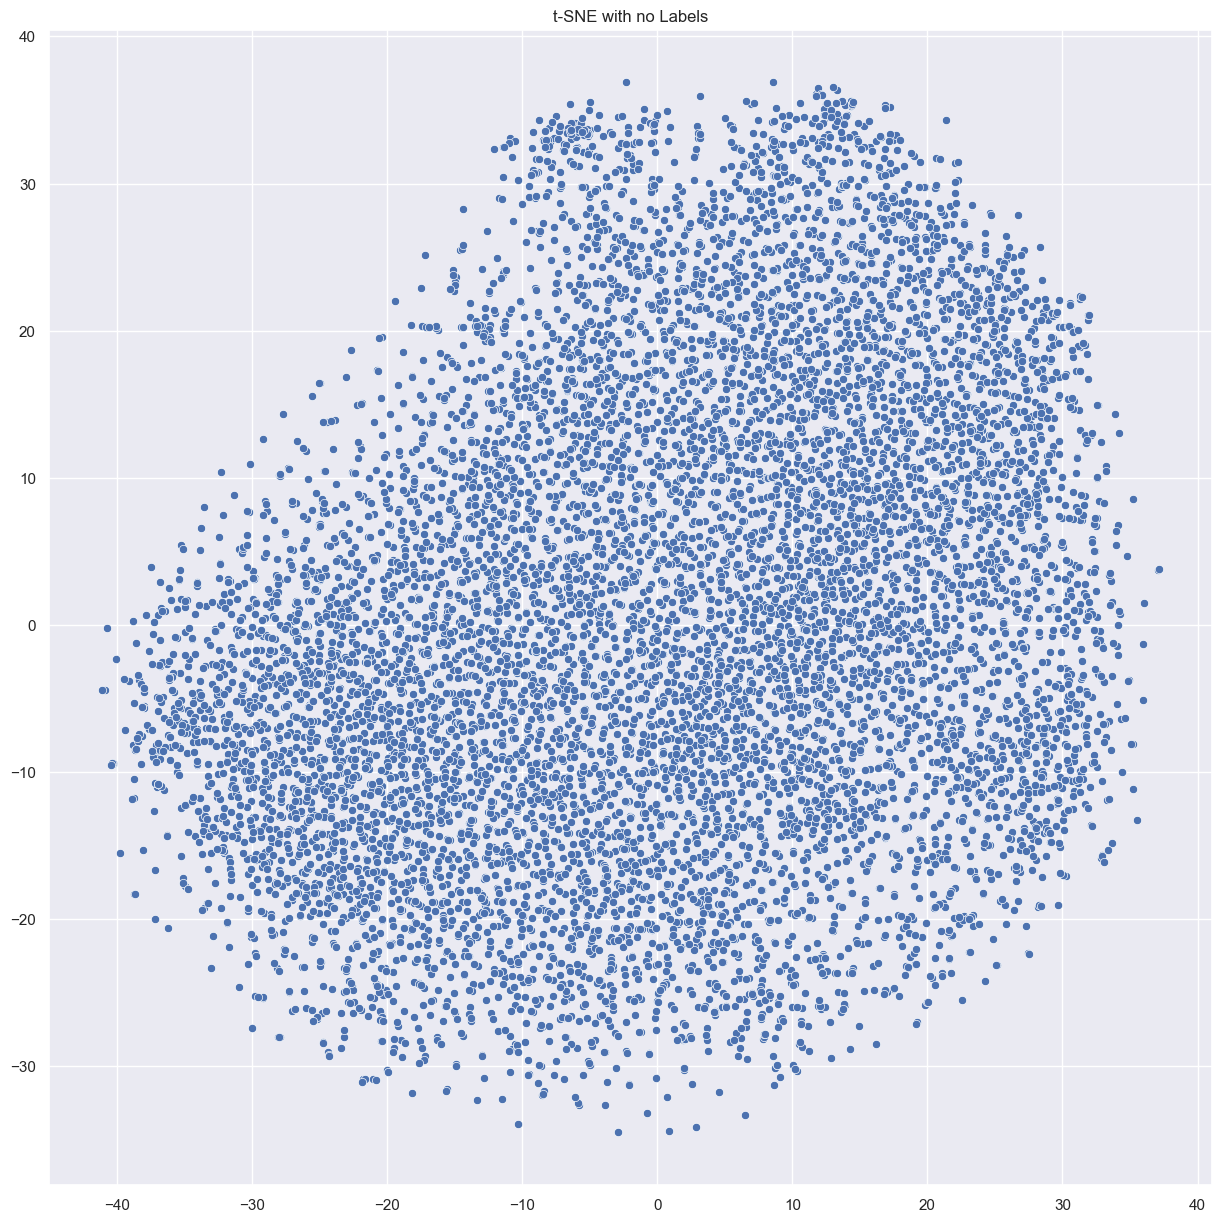

In [35]:
# sns settings
sns.set_theme(rc={'figure.figsize':(15,15)})

# plot
sns.scatterplot(x = X_embedded[:,0],y = X_embedded[:,1])
plt.title('t-SNE with no Labels')
# plt.savefig("t-sne_covid19.png")
plt.show()

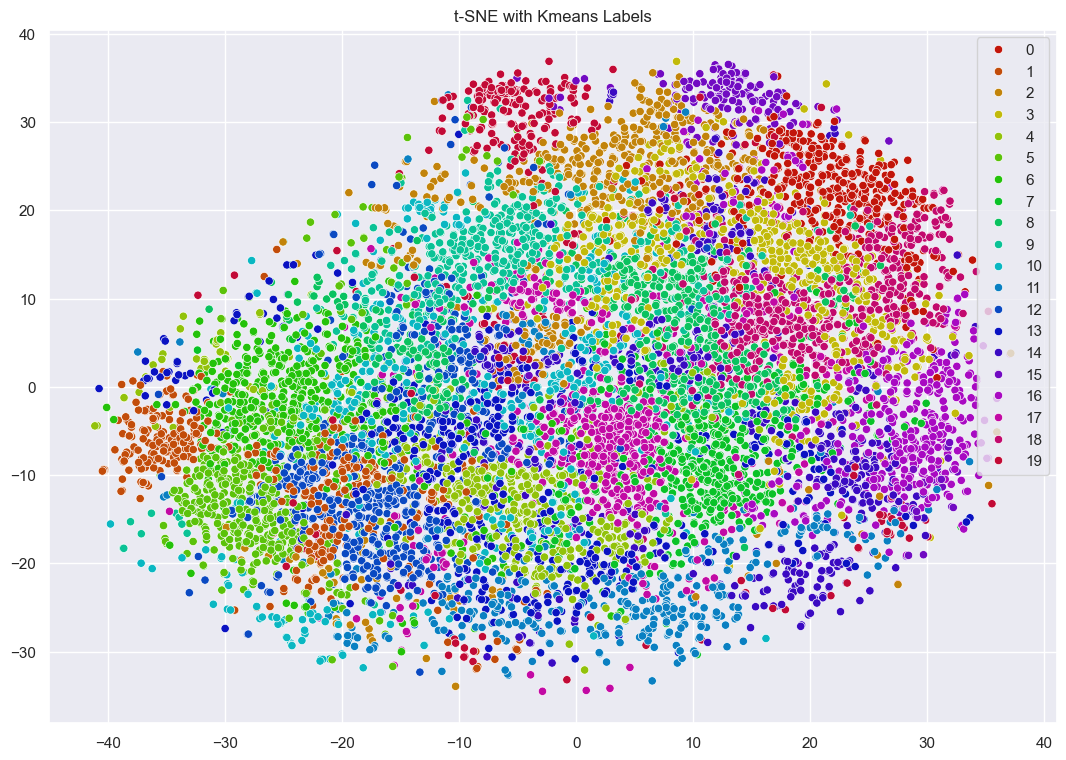

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set_theme(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
# plt.savefig("improved_cluster_tsne.png")
plt.show()